![All Logo](https://github.com/swamichandra/AnalyzeFakeNews/blob/master/images/logo.png?raw=true)

# Analyze Fake News using IBM Watson Natural Language Understanding

### Author: Swami Chandrasekaran
> Menace caused by fake news are far more reaching & impacting and poses major global risks to societies. Understanding the patterns, trends and other insights about fake news is very essential in understanding its impact on the society.

This notebook shows how to enrich & analyze a fake news dataset using Watson Natural Language Understanding (NLU) API to detect interesting insights and anomalies. We will analyze fake news dataset availble from https://www.kaggle.com/mrisdal/fake-news using Watson NLU, IBM Watson Studio, Python, Matplotlib, Seaborn and Pixie Dust.

We'll load the fake news data in CSV format using Pandas and do some basic descriptive analysis. Then, we will then enrich the columns in the dataset using Watson NLU API to get the sentiment, document emotion, keywords, and entities. We will then perform additonal descriptive analysis on the enriched dataset.

You will use data about to graph the relationships between various properties, for example, the emotion expressed by a given author, the relationship between spam score and the sentiment score of a given article.


Some familiarity with Python is recommended. 

[Watson NLU](https://www.ibm.com/watson/services/natural-language-understanding/) is one of the API's on the Watson Developer Cloud platform that let's you analyze text to extract meta-data from content such as concepts, entities, keywords, categories, sentiment, emotion, relations, semantic roles, using deep natural language understanding.

We will use for the purposes of this notebook 3 visualization libraries. The goal is to show the art of the possible with each one of these. This notebook contains the steps and code to get you started with visualizing data with all these libraries.
1. [Matplotlib](https://matplotlib.org/) - a plotting library for the Python and its numerical mathematics extension NumPy
1. [Seaborn](https://seaborn.pydata.org/) - a Python visualization library based on matplotlib.
1. [PixieDust](https://www.ibm.com/cloud/pixiedust) is an open source Python helper library that works as an add-on to Jupyter notebooks to improve the user experience of working with data.

<a id="toc"></a>
## Table of contents

This notebook has the following sections:
1. [Data & Questions](#data)
1. [Load the data](#data_set)
1. [Prepare the data](#prepare)
1. [Visualize the data](#visualize)
1. [Enrich the data using Watson NLU](#enrich_data_set)
1. [Visualize the enriched data](#enrich_visualize)
1. [Summary and next steps](#summary)

<a id="data"></a>
## 1. Data & Questions
The "Fake News" dataset is available from Kaggle, and it contains text and metadata from 244 websites and represents 12,999 posts in total. Go to the <a href="https://www.kaggle.com/mrisdal/fake-news" target="_blank">Getting Real about Fake News</a> to download the dataset that is made available in CSV format. The dataset is made available in a CSV format and has the following characteristics,
- Number of rows = 17948
- Number of columns = 20
- Columns: uuid, ord_in_thread, author, published, title, text, language, crawled, site_url, country, domain_rank, thread_title, spam_score, main_img_url, replies_count, participants_count, likes, comments, shares, type

### The Questions
Let's go out and try to find the answers and insights to the following questions,
1. What is the count of news stories group by its type and country of publication?
1. What is the distribution of fake news by published day of the week?
1. What is the count of news stories grouped by site url that publish them?
1. Who are the top-10 fake news authors and respective count of published news articles?
1. Who are the top 25 authors?
1. What is the heatmap of the sentiment of top-15 authors by the type of fake news?
1. What are most frequent keywords and phrases?
1. Which words are used when the authors are angry or disgusted?
1. Which entity types were detected the most?
1. What is the relationship between the spam score and the overall emotion type?
1. What is the top emotion across all fake news?
1. How does a view of sentiment score and predominant emotion look like by day of the week?

<a id="data_set"></a>
## 2. Load the data 
1. Upload the CSV file to Data Science Experience. See <a href="http://datascience.ibm.com/docs/content/analyze-data/load-and-access-data.html#load-data-from-local-files" target="_blank">here</a> for more details.
1. Click the Find and Add Data icon (Shows the find data icon.), and then browse a data file or drag it into your notebook sidebar.
1. Click in an empty code cell in your notebook and then click the Insert to code link below the file and choose how to load the data. 
1. Run the next cell to import pandas and Brunel libraries, load the data into a pandas DataFrame, and display the first five rows of data:

### Install and Import the Packages

#### Please comment out and install the right set of modules / libraries that you may need. Be sure all of your imports work properly before proceeding any further. 

In [1]:
# Install the Watson Developer Cloud Python SDK. This is a one time activity.
!pip install --upgrade watson-developer-cloud

# Install PixieDust
!pip install --user --upgrade pixiedust

# Install wordcloud
!pip install wordcloud 

# Install Seaborn
!pip install seaborn

#### Please be sure all of your imports work properly without any errors before proceeding any further. If not go back and uncomment or add the necessary pip install commands.

In [74]:
import datetime
import json
import numpy as np
import operator
import pandas as pd
import random
import requests
import string
import sys
from os.path import join, dirname
from wordcloud import WordCloud, STOPWORDS
from io import StringIO
from functools import reduce

# Import the packages including the Watson Developer Cloud Python SDK libs
import watson_developer_cloud
from watson_developer_cloud import NaturalLanguageUnderstandingV1
from watson_developer_cloud.natural_language_understanding_v1 import Features, EntitiesOptions, KeywordsOptions, EmotionOptions, SentimentOptions

# Import all the visualization libs
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
matplotlib.style.use('seaborn-pastel')
import seaborn as sns
import pixiedust
from pixiedust.display import *

# hide all warnings
import warnings
warnings.filterwarnings('ignore')

### Restart Kernel
>Required after installs/upgrades only.

If any libraries were just installed or upgraded, restart the kernel before continuing. After this has been done once, you might want to comment out the !pip install lines above for cleaner output and a faster "Run All".

### Define some global variables

In [3]:
# Watson Natural Launguage Understanding (NLU)
WATSON_NLU_USERNAME = 'YOUR WATSON NLU USERID'
WATSON_NLU_PASSWORD = 'YOUR WATSON NLU PASSWORD'

In [4]:
# Create connections to the Watson services using the client SDK
nlu = NaturalLanguageUnderstandingV1(version='2017-02-27', username=WATSON_NLU_USERNAME, password=WATSON_NLU_PASSWORD)

### Read the CSV File
After you download the fake news dataset, you have the option of loading the CSV file into When you Read the CSV file that as a data asset into Watson Studio. Click on the 10/01 (upper right), then drop the CSV file.

If you want to run this notebook locally, then you will have need to read the CSV file. Here is an example / representative code snippet that you can leverage.

```python
df_cust_comp_orig = pd.read_csv("path to CSV_FILE")
print('Successfully read the CSV file ....')
```

Select the cell below and place your cursor on an empty line below the comment. Put in the credentials for the file you want to enrich by clicking on the 10/01 (upper right), then click _"Insert Pandas DataFrame"_ to code under the file you want to enrich.

Change the inserted datframe name to ```df_data_fake_orig```

In [5]:
# The code was removed by DSX for sharing.

In [6]:
print('Successfully read the CSV file with the following shape: ' 
      + str(df_data_fake_orig.shape))

Successfully read the CSV file with the following shape: (12999, 20)


As the NLU Lite plan (free tier) has limits on the number of calls allowed per day, we need to take the top (or) a random sample of N records from the data set and call NLU for that set. 

<font color='red'><h4><b>NOTE: </b>For the purposes of this notebook and analysis, we will read only 100 records. I would __not recommend__ you do this when do a full data analysis. But again this step is for the purposes of the notebook.</h4></font>

In [7]:
__NUMBER_OF_CSV_RECORDS_TO_READ = 100

In [8]:
random_rows = np.random.choice(df_data_fake_orig.index.values, __NUMBER_OF_CSV_RECORDS_TO_READ)
df_data_fake_orig = df_data_fake_orig.ix[random_rows]

In [9]:
#list(df_data_fake_orig['text'][:1])

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="prepare"></a>
## 2. Prepare the data 
Let's prepare the data and perfomr some basic data cleansing and munging.

In [10]:
print('Number of rows BEFORE pruning: ', df_data_fake_orig.shape[0])

Number of rows BEFORE pruning:  100


### Remove records that have empty or shorter length text

In [11]:
# replace empty text cells to NaN and drop
df_data_fake_orig['text'].replace('', np.nan, inplace=True)
df_data_fake_orig.dropna(subset=['text'], inplace=True)

# Lets drop all records that have text less than a certain threshold of characters
df_data_fake_orig = df_data_fake_orig[~(df_data_fake_orig.text.str.len() < 20)]

### Convert to date time format and extract piece parts

In [12]:
# Convert the 'published' column that is in string format to datetime format.
# Will be very useful for performing data specific operations and grouping
df_data_fake_orig['published'] = pd.to_datetime(df_data_fake_orig['published'])

# Add a column to specify the day of the week, month of the year and year
# Lets extract out the month and year of the published article and add them as seperate columns in the dataframe
df_data_fake_orig['published_DoW'] = pd.to_datetime(df_data_fake_orig['published']).dt.weekday_name
df_data_fake_orig['published_month'] = pd.to_datetime(df_data_fake_orig['published']).dt.strftime("%B")
df_data_fake_orig['published_Qr'] = pd.to_datetime(df_data_fake_orig['published']).dt.quarter
df_data_fake_orig['published_year'] = pd.to_datetime(df_data_fake_orig['published']).dt.year
df_data_fake_orig['published_month_year'] = df_data_fake_orig["published"].apply(lambda x: x.strftime("%x"))

#df_data_fake_orig.head(2)

In [13]:
print('Number of rows AFTER pruning: ', df_data_fake_orig.shape[0])

Number of rows AFTER pruning:  97


<div style="text-align: right">[Back to the top](#toc)</div>

<a id="visualize"></a>
## 4. Visualize the data
Let's create some charts and diagrams to describe the dataset and have some key questions answered.

PixieDust brings you the power to create compelling visuals fast, no coding necessary. You can use PixieDust immediately online in the IBM Cloud, or on your local machine. See detailed documentation on using PixieDust at __[Use PixieDust](https://ibm-cds-labs.github.io/pixiedust/use.html)__.

### First order of business is to describe the data
Run the next cell to describe the data

In [14]:
print('Number of rows in the dataset: ', df_data_fake_orig.shape[0])
print('Number of columns in the dataset: ', df_data_fake_orig.shape[1])
print('Following are the list of column type organized using groupby:', df_data_fake_orig.columns.to_series().groupby(df_data_fake_orig.dtypes).groups)

Number of rows in the dataset:  97
Number of columns in the dataset:  25
Following are the list of column type organized using groupby: {dtype('float64'): Index(['domain_rank', 'spam_score'], dtype='object'), dtype('<M8[ns]'): Index(['published'], dtype='object'), dtype('O'): Index(['uuid', 'author', 'title', 'text', 'language', 'crawled', 'site_url',
       'country', 'thread_title', 'main_img_url', 'type', 'published_DoW',
       'published_month', 'published_month_year'],
      dtype='object'), dtype('int64'): Index(['ord_in_thread', 'replies_count', 'participants_count', 'likes',
       'comments', 'shares', 'published_Qr', 'published_year'],
      dtype='object')}


### What is the count of news stories group by its type and country of publication?
Run the next cell to get a simple chart that shows the distribution of the news stories by it type using Seaborn.

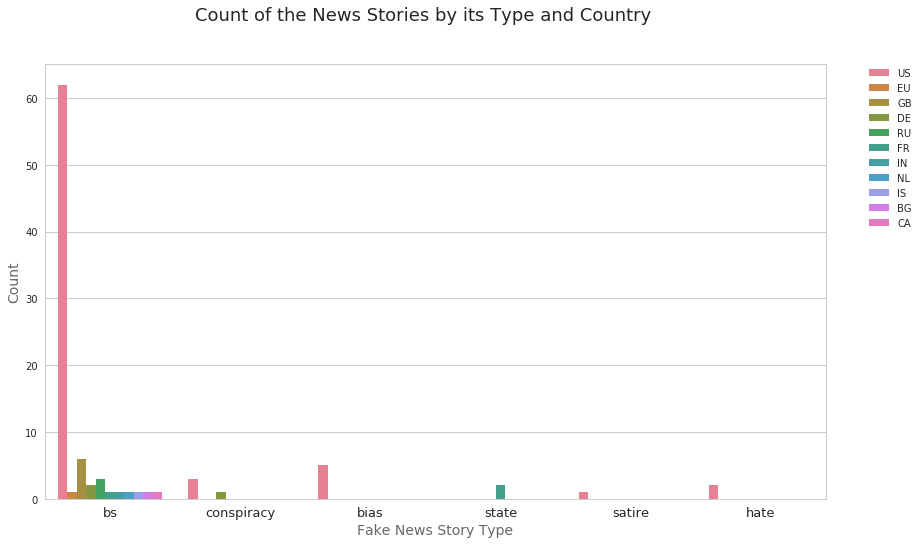

In [76]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()
# the size of A4 paper
fig.set_size_inches(12, 8)

sns.countplot(x=df_data_fake_orig["type"], hue=df_data_fake_orig["country"], data=df_data_fake_orig, palette="husl");

# set the chart title, size and axis labels
fig.set_size_inches(14, 8)
fig.suptitle('Count of the News Stories by its Type and Country', fontsize=18)
ax.set_xlabel("Fake News Story Type", size=14, alpha=0.7)
ax.set_ylabel("Count", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=13)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### What is the distribution of fake news by published day of the week?
Run the next cell to get a simple chart that shows the distribution of which day of the week the fake news story was published. We will use Matplotlib for this chart.

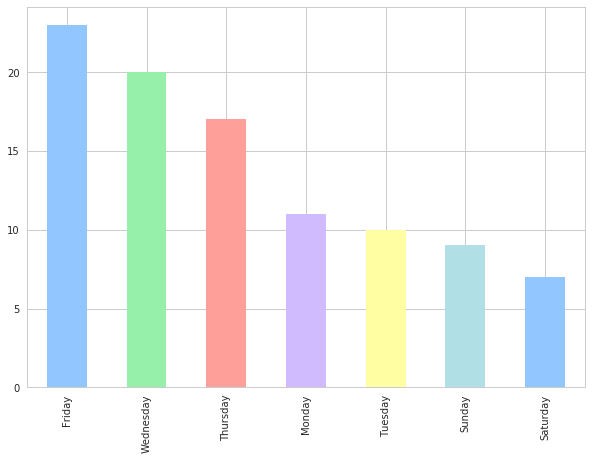

In [75]:
# Plot the count of Languages of the News Story
# bar2 = Bar(df_data_fake_orig.language.value_counts(), title="News Stories by Type", xlabel='Story Language', ylabel='Count', legend="top_right", tools='hover,pan,wheel_zoom,box_zoom,reset,resize', width=700, height=400)
df_data_fake_orig.published_DoW.value_counts().plot(kind='bar', figsize=(10,7))

# show the results
#show(bar2)

### What is the count of news stories grouped by site url that publish them?
Run the next cell to show the relationship between the count of news stories grouped by the sites that publish them. We will use Seaborn for this chart.

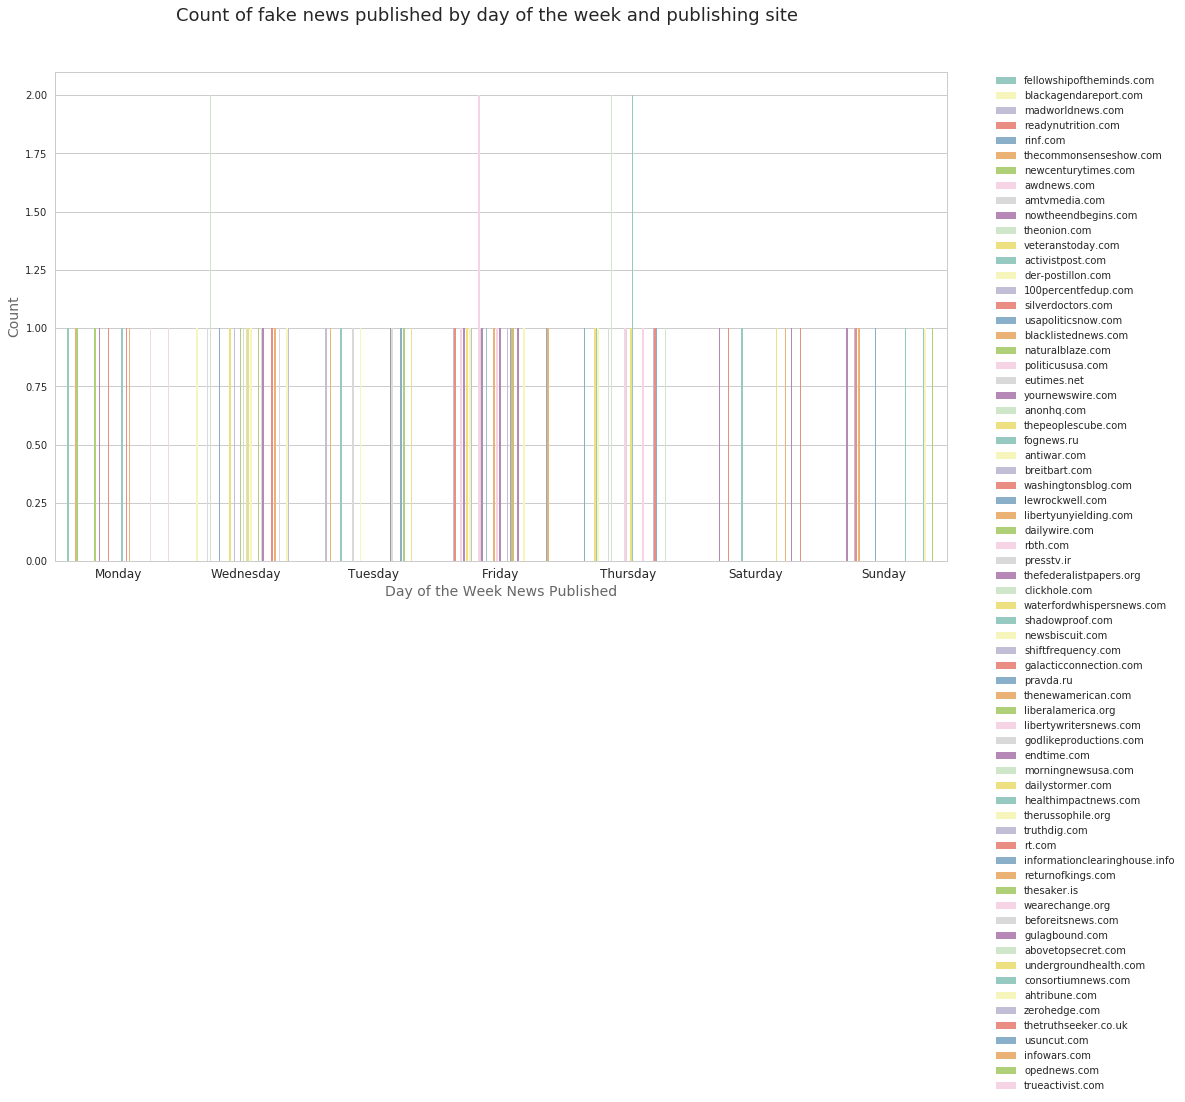

In [77]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()

sns.countplot(x="published_DoW", hue="site_url", data=df_data_fake_orig, palette="Set3")

# set the chart title, size and axis labels
fig.set_size_inches(16, 9)
fig.suptitle('Count of fake news published by day of the week and publishing site', fontsize=18)
ax.set_xlabel("Day of the Week News Published", size=14, alpha=0.7)
ax.set_ylabel("Count", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=12)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### Who are the top-10 fake news authors and respective count of published news articles?

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), <a list of 10 Text xticklabel objects>)

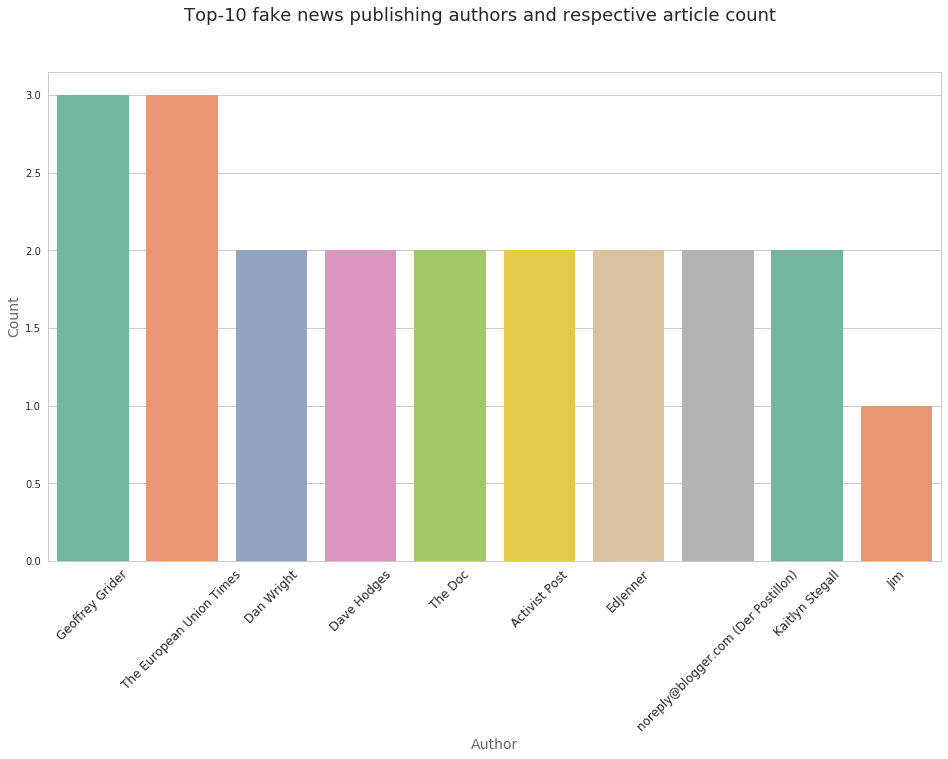

In [78]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()

sns.countplot(x="author", palette="Set2", 
              data=df_data_fake_orig, 
              order=df_data_fake_orig['author'].value_counts().iloc[:10].index)

# set the chart title, size and axis labels
fig.set_size_inches(16, 9)
fig.suptitle('Top-10 fake news publishing authors and respective article count', fontsize=18)
ax.set_xlabel("Author", size=14, alpha=0.7)
ax.set_ylabel("Count", size=14, alpha=0.7)
plt.xticks(rotation=45, fontsize=12)

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="enrich_data_set"></a>
## 5. Enrich the data using Watson NLU
Now let's enrich the data set using Watson Natural Language Understanding. We will enrich for getting the following,
- Sentiment
- Emotion
- Entities
- Keywords
 
See detailed API documentation for the Watson NLU API at __[Watson NLU API Reference](https://www.ibm.com/watson/developercloud/natural-language-understanding/api/v1/)__.

### Enrich using Watson NLU

In [23]:
%%time

# define the list of enrichments to apply using Watson NLU
# See here for the enrichments you can apply https://www.ibm.com/watson/developercloud/doc/natural-language-understanding/
# If you are modifying this script add or remove the enrichments as needed
# Define the list of features to get enrichment values for entities, keywords, emotion and sentiment
features = Features(entities=EntitiesOptions(limit=3), 
                    keywords=KeywordsOptions(limit=5), 
                    emotion=EmotionOptions(), 
                    sentiment=SentimentOptions())

# Create a list to store the enriched data
overallSentimentScore = []
overallSentimentType = []
highestEmotion = []
highestEmotionScore = []
kywords = []
entities = []

# Simple counter to track NLU usage
usage = 0

# Let's use the text column from the fake news data set and enrich it using Watson NLU
# Go thru every reponse and enrich the text using NLU
for text in df_data_fake_orig['text']:
    # We are assuming English to avoid errors when the language cannot be detected.
    enriched_json = nlu.analyze(text=text, features=features, language='en')
    #print(enriched_json)

    # get the SENTIMENT score and type
    if 'sentiment' in enriched_json:
        if('score' in enriched_json['sentiment']["document"]):
            overallSentimentScore.append(enriched_json["sentiment"]["document"]["score"])
        else:
            overallSentimentScore.append('0')

        if('label' in enriched_json['sentiment']["document"]):
            overallSentimentType.append(enriched_json["sentiment"]["document"]["label"])
        else:
            overallSentimentType.append('0')
    else:
        overallSentimentScore.append('0')
        overallSentimentType.append('0')

    # read the EMOTIONS into a dict and get the key (emotion) with maximum value
    if 'emotion' in enriched_json:
        me = max(enriched_json["emotion"]["document"]["emotion"].items(), key=operator.itemgetter(1))[0]
        highestEmotion.append(me)
        highestEmotionScore.append(enriched_json["emotion"]["document"]["emotion"][me])

    else:
        highestEmotion.append("")
        highestEmotionScore.append("")

    # Iterate and get KEYWORDS with a confidence of over 70%
    if 'keywords' in enriched_json:
        tmpkw = []
        for kw in enriched_json['keywords']:
            if(float(kw["relevance"]) >= 0.7):
                tmpkw.append(kw["text"])
        # Convert multiple keywords in a list to a string and append the string
        kywords.append(', '.join(tmpkw))
    else:
        kywords.append("")

    # Iterate and get Entities with a confidence of over 30%
    if 'entities' in enriched_json:
        tmpent = []
        for ent in enriched_json['entities']: 
            if(float(ent["relevance"]) >= 0.3):
                tmpent.append(ent["type"])

        # Convert multiple entities in a list to a string and append the string
        entities.append(', '.join(tmpent))
    else:
        entities.append("")
        
    # Get the usage information for the request
    if 'usage' in enriched_json:
        usage = usage + int(enriched_json["usage"]["text_units"])
        

# Create columns from the list and append to the DataFrame
if highestEmotion:
    df_data_fake_orig['TextHighestEmotion'] = highestEmotion
if highestEmotionScore:
    df_data_fake_orig['TextHighestEmotionScore'] = highestEmotionScore

if overallSentimentType:
    df_data_fake_orig['TextOverallSentimentType'] = overallSentimentType
if overallSentimentScore:
    df_data_fake_orig['TextOverallSentimentScore'] = overallSentimentScore

df_data_fake_orig['TextKeywords'] = kywords
df_data_fake_orig['TextEntities'] = entities

# Choose first of Keywords,Concepts, Entities
df_data_fake_orig["MaxTextKeywords"] = df_data_fake_orig["TextKeywords"].apply(lambda x: x.split(',')[0])
df_data_fake_orig["MaxTextEntity"] = df_data_fake_orig["TextEntities"].apply(lambda x: x.split(',')[0])

print('Successfully enriched the dataframe using Watson NLU. Usage was ' + str(usage) + " text units (Number of 10,000-character units processed)")

Successfully enriched the dataframe using Watson NLU. Usage was 108 text units (Number of 10,000-character units processed)
CPU times: user 1.54 s, sys: 124 ms, total: 1.66 s
Wall time: 1min 11s


#### Print the details and shape of the dataframe

In [24]:
#df_data_fake_orig.NewsOverallSentimentScore = df_data_fake_orig.NewsOverallSentimentScore.astype(np.float64)
df_data_fake_orig = df_data_fake_orig.convert_objects(convert_numeric=True)

print("Number of rows after enrichment: ", df_data_fake_orig.shape[0])
print("Number of columns after enrichment: ", df_data_fake_orig.shape[1])
print('Following are the list of column type organized using groupby:', df_data_fake_orig.columns.to_series().groupby(df_data_fake_orig.dtypes).groups)

Number of rows after enrichment:  97
Number of columns after enrichment:  33
Following are the list of column type organized using groupby: {dtype('float64'): Index(['domain_rank', 'spam_score', 'TextHighestEmotionScore',
       'TextOverallSentimentScore'],
      dtype='object'), dtype('<M8[ns]'): Index(['published'], dtype='object'), dtype('O'): Index(['uuid', 'author', 'title', 'text', 'language', 'crawled', 'site_url',
       'country', 'thread_title', 'main_img_url', 'type', 'published_DoW',
       'published_month', 'published_month_year', 'TextHighestEmotion',
       'TextOverallSentimentType', 'TextKeywords', 'TextEntities',
       'MaxTextKeywords', 'MaxTextEntity'],
      dtype='object'), dtype('int64'): Index(['ord_in_thread', 'replies_count', 'participants_count', 'likes',
       'comments', 'shares', 'published_Qr', 'published_year'],
      dtype='object')}


<div style="text-align: right">[Back to the top](#toc)</div>

### Optionally save the enriched results to a CSV file

Select the cell below and place your cursor on an empty line below the comment. Put in the credentials for the file you want to enrich by clicking on the 10/01 (upper right), then click Insert to code under the file you want to enrich, and choose Insert Credentials.

Change the inserted variable name to credentials_1

In [25]:
# The code was removed by DSX for sharing.

In [26]:
def put_file(credentials, local_file_name):
    """Put the file in IBM Object Storage."""
    f = open(local_file_name,'r',encoding="utf-8")
    my_data = f.read()
    data_to_send = my_data.encode("utf-8")
    url1 = ''.join(['https://identity.open.softlayer.com', '/v3/auth/tokens'])
    data = {'auth': {'identity': {'methods': ['password'],
            'password': {'user': {'name': credentials['username'],'domain': {'id': credentials['domain_id']},
            'password': credentials['password']}}}}}
    headers1 = {'Content-Type': 'application/json'}
    resp1 = requests.post(url=url1, data=json.dumps(data), headers=headers1)
    resp1_body = resp1.json()
    for e1 in resp1_body['token']['catalog']:
        if(e1['type']=='object-store'):
            for e2 in e1['endpoints']:
                        if(e2['interface']=='public'and e2['region']=='dallas'):
                            url2 = ''.join([e2['url'],'/', credentials['container'], '/', local_file_name])
    s_subject_token = resp1.headers['x-subject-token']
    headers2 = {'X-Auth-Token': s_subject_token, 'accept': 'application/json'}
    resp2 = requests.put(url=url2, headers=headers2, data = data_to_send )
    resp2.raise_for_status()
    print('%s saved to IBM Object Storage. Status code=%s.' % (localfilename, resp2.status_code))

#### Uncomment the following cell if you want to store the results in a CSV 

In [27]:
'''
CUST_CSV_FILE = "fake_news.csv"

# Build the enriched file name from the original filename.
localfilename = 'enriched_' + datetime.date.today().strftime("%B_%d_%Y") + "_" + CUST_CSV_FILE

# Write a CSV file from the enriched pandas DataFrame.
df_data_fake_orig.to_csv(localfilename, sep=',', index = False, )

# Use the above put_file method with credentials to put the file in Object Storage.
put_file(credentials_1, localfilename)

print('Successfully saved the enriched fake news CSV file')
'''

'\nCUST_CSV_FILE = "fake_news.csv"\n\n# Build the enriched file name from the original filename.\nlocalfilename = \'enriched_\' + datetime.date.today().strftime("%B_%d_%Y") + "_" + CUST_CSV_FILE\n\n# Write a CSV file from the enriched pandas DataFrame.\ndf_data_fake_orig.to_csv(localfilename, sep=\',\', index = False, )\n\n# Use the above put_file method with credentials to put the file in Object Storage.\nput_file(credentials_1, localfilename)\n\nprint(\'Successfully saved the enriched fake news CSV file\')\n'

<div style="text-align: right">[Back to the top](#toc)</div>

<a id="enrich_visualize"></a>
## 6. Visualize Enriched Data
Now that we have enriched the fake news data set using Watson NLU, let us create some interesting visualization to understand and uncover relationships (and correlations) in the data.

### Who are the top 25 authors?
Run the next cell to get the top 25 authors of the fake news

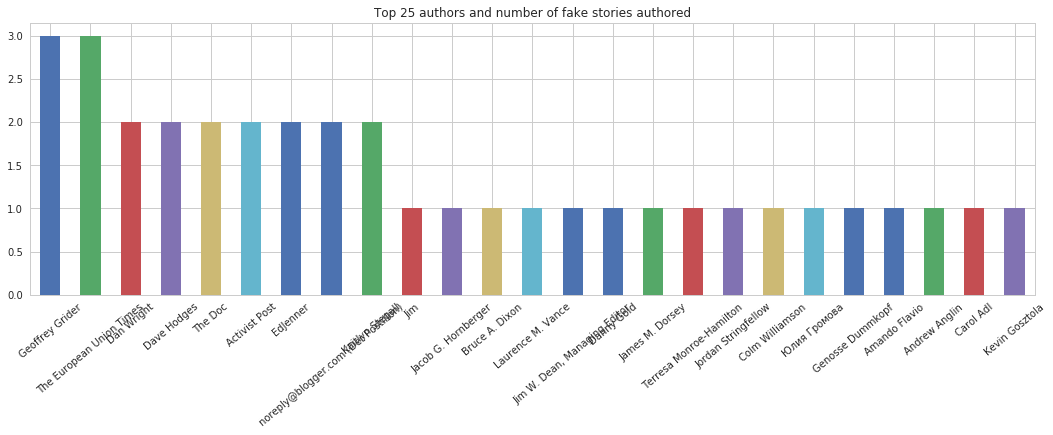

In [79]:
#df_data_fake_orig.author.value_counts().nlargest(25)
df_data_fake_orig.author.value_counts().nlargest(25).plot.bar(figsize=(18,5), 
                                   title="Top 25 authors and number of fake stories authored", y="Count", rot = 40)

### What is the heatmap of the sentiment of top-15 authors by the type of fake news?
Let's analyze the general sentiment of the top authors based on what they have written.

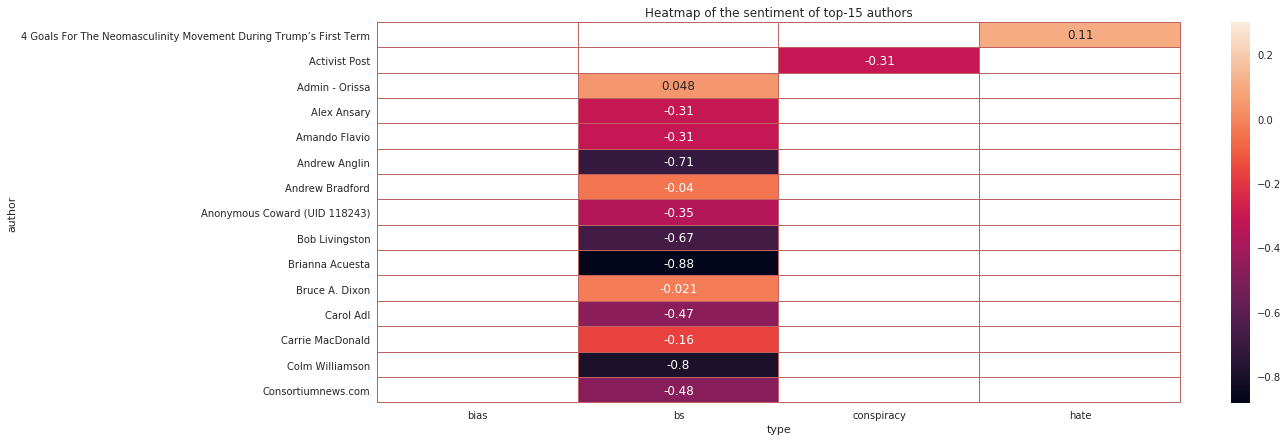

In [80]:
df4 = df_data_fake_orig.pivot_table(index='author'[0:10], columns='type', values='TextOverallSentimentScore', 
                                    aggfunc=np.median).head(15)
plt.figure(figsize=(18, 7))
plt.title('Heatmap of the sentiment of top-15 authors')
sns.heatmap(df4, annot=True, linewidths=0.02, vmax=.3, linecolor='#BF6262')

### What are most frequent keywords and phrases?
Now let's create a word cloud from the keywords extracted using Watson NLU.
> We will use the word_cloud package. https://github.com/amueller/word_cloud

(-0.5, 799.5, 399.5, -0.5)

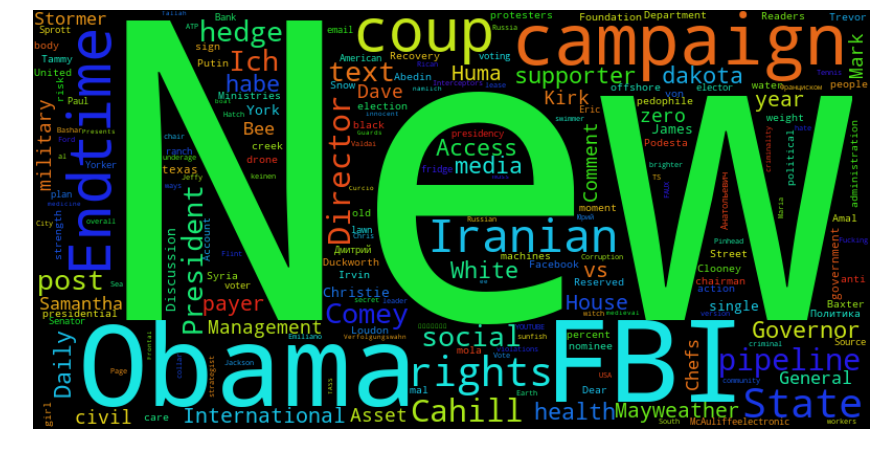

In [30]:
#Convert all the required text into a single string here and store them in word_string
kw = df_data_fake_orig['TextKeywords'].str.cat(sep=', ')

# Let's take out the most obvious words
stopwords = ["Hello", "Hi","hello","hi","thanks","ok", "trump", "clinton", "hillary", "donald"]

# Generate a word cloud image
wordcloud = WordCloud(stopwords=stopwords, width=800, height=400, background_color='black').generate(kw)
fig, ax = plt.subplots()
plt.imshow(wordcloud, interpolation='bilinear')
fig.set_size_inches(15, 9)
plt.axis("off")

### Which words are used when the authors are angry or disgusted?
> We will use the word_cloud package. https://github.com/amueller/word_cloud

(-0.5, 799.5, 399.5, -0.5)

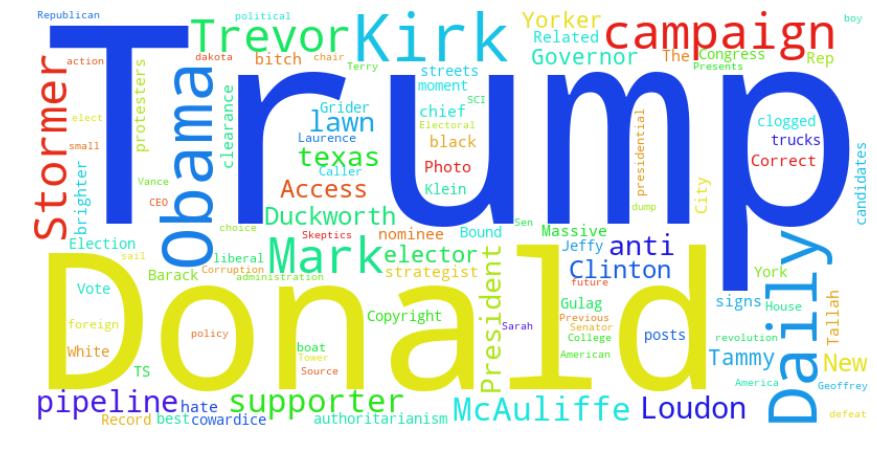

In [31]:
# get only angry & disgust emotion type
df_anger_disgust = df_data_fake_orig.loc[(df_data_fake_orig['TextHighestEmotion'] == 'anger') | 
                                         (df_data_fake_orig['TextHighestEmotion'] == 'disgust')]

# Let's take out the most obvious words
stopwords = ["Hello", "Hi","hello","hi","thanks","ok"]

# Generate a word cloud image
text = df_anger_disgust['TextKeywords']
wordcloud = WordCloud(width=800, height=400, stopwords=stopwords, background_color="white").generate(' '.join(df_anger_disgust['TextKeywords']))
fig, ax = plt.subplots()
plt.imshow(wordcloud, interpolation='bilinear')
fig.set_size_inches(15, 9)
plt.axis("off")

### Which entity types were detected the most?

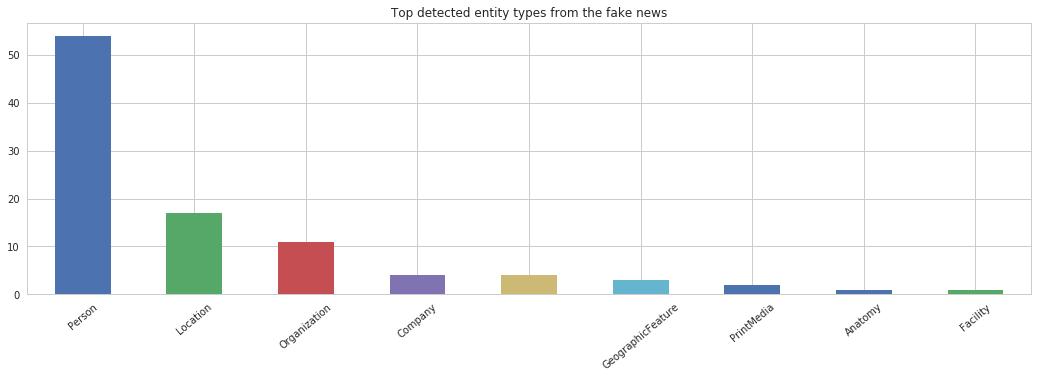

In [81]:
#df_data_fake_orig.author.value_counts().nlargest(25)
df_data_fake_orig.MaxTextEntity.value_counts().nlargest(10).plot.bar(figsize=(18,5), 
                                   title="Top detected entity types from the fake news", y="Count", rot = 40)

### What is the relationship between the spam score and the overall emotion type?
Let's analyze the overall emotion type to the spam score grouped by story type as a strip plot.

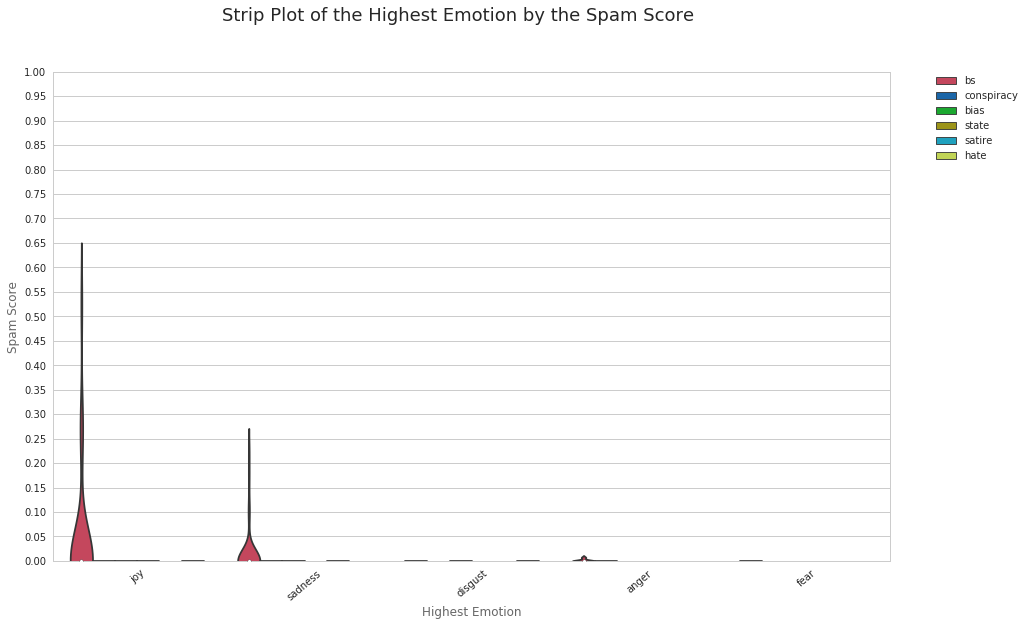

In [104]:
sns.set(style="whitegrid", color_codes=True)
flatui = ["#D93250", "#0468BF", "#04BF20", "#B2A703", "#04B2D9", "#D0E941"]

fig, ax = plt.subplots()
sns.violinplot(x=df_data_fake_orig["TextHighestEmotion"], y=df_data_fake_orig["spam_score"], 
              data=df_data_fake_orig, 
              hue=df_data_fake_orig["type"], palette=flatui);


# set the chart title, size and axis labels
fig.set_size_inches(15, 9)
fig.suptitle('Strip Plot of the Highest Emotion by the Spam Score', fontsize=18)
ax.set_xlabel("Highest Emotion", size=12, alpha=0.7)
ax.set_ylabel("Spam Score", size=12, alpha=0.7)
ax.yaxis.set_major_locator(ticker.MultipleLocator(.05))
#ax.set_yscale('log')
plt.xticks(rotation=40, fontsize=10)
plt.gca().set_ylim(0,1)
#plt.yticks(x[:-1])
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### What is the top emotion across all fake news?

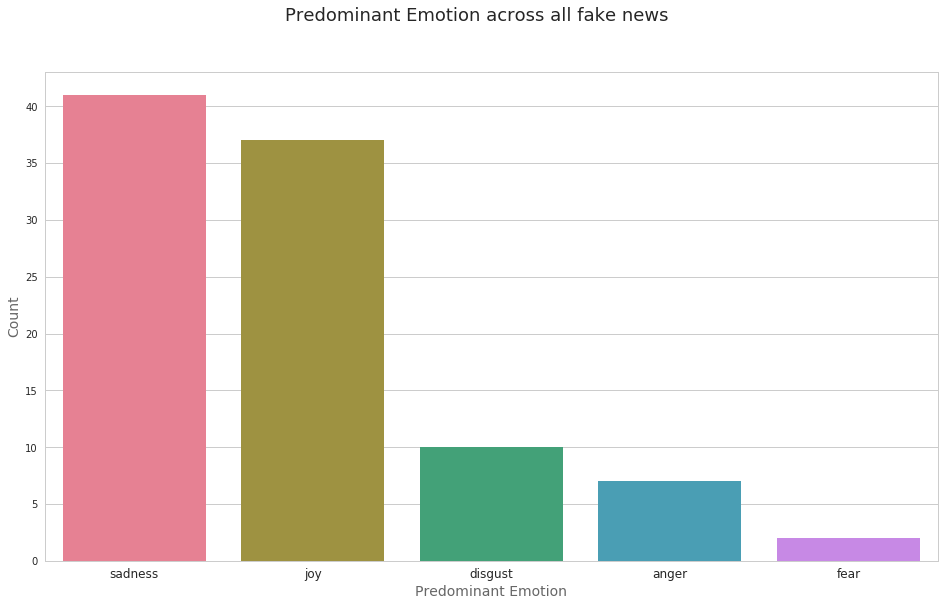

In [112]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()

sns.countplot(x="TextHighestEmotion", palette="husl", 
              data=df_data_fake_orig, 
              order=df_data_fake_orig['TextHighestEmotion'].value_counts().index)

# set the chart title, size and axis labels
fig.set_size_inches(16, 9)
fig.suptitle('Predominant Emotion across all fake news', fontsize=18)
ax.set_xlabel("Predominant Emotion", size=14, alpha=0.7)
ax.set_ylabel("Count", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=12)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

### How does a view of sentiment score and predominant emotion look like by day of the week?

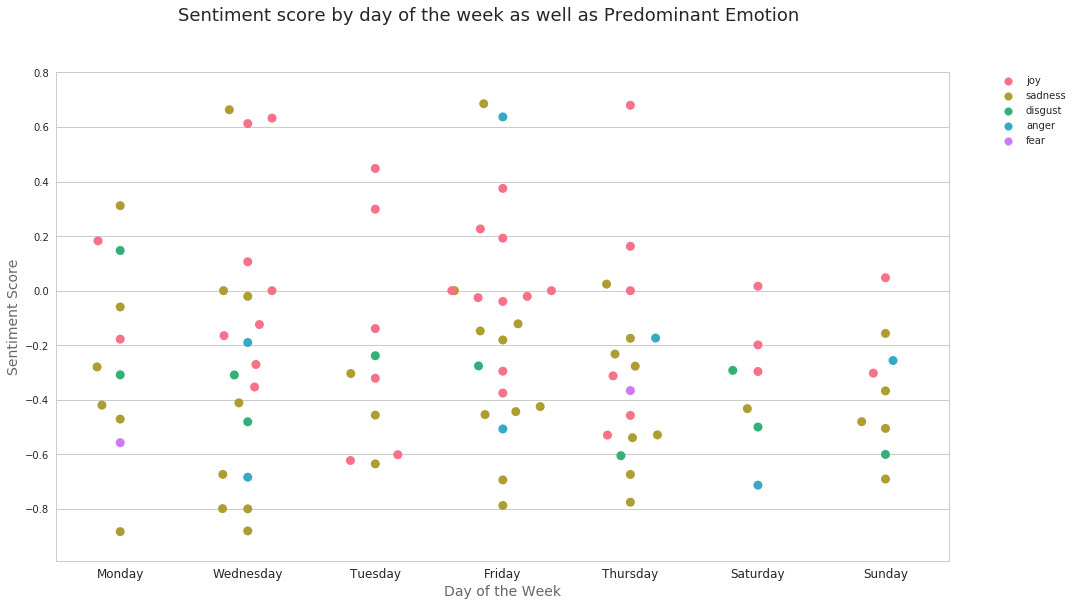

In [114]:
sns.set(style="whitegrid", color_codes=True)
fig, ax = plt.subplots()

sns.swarmplot(x="published_DoW", y="TextOverallSentimentScore", data=df_data_fake_orig, 
               hue="TextHighestEmotion", palette="husl", size=9)

# set the chart title, size and axis labels
fig.set_size_inches(16, 9)
fig.suptitle('Sentiment score by day of the week as well as Predominant Emotion', fontsize=18)
ax.set_xlabel("Day of the Week", size=14, alpha=0.7)
ax.set_ylabel("Sentiment Score", size=14, alpha=0.7)
plt.xticks(rotation=0, fontsize=12)
# Legend outside of the fig
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

stle
<div style="text-align: right">[Back to the top](#toc)</div>

#### Analyze using Pixiedust

In [36]:
display(df_data_fake_orig)

<a id="enrich_visualize"></a>
## 7. Summary and Next Steps
Addressing fake news that travels at a very rapid pace in this connected age, requires a deeper understanding of how the creators 
of fake news author them as well as the surrounding context. We need AI systems like NLU and algorithms built around it to review the news, come up with scores that are easily understandable form and supported by evidence for the news readers. This easily accessible information will aid consumers from making informed decisions and also in the reduction of fake news proliferation. Having said so, some of the other things you could do and try include,

1. Import the enriched CSV into your favorite business intelligence (BI) tool and perform further descriptive & statistical analysis.
1. Use the Watson NLU enriched features as part of a predictive model you may already have.
1. Build a fake news scoring model.
1. Build a predictive ML model to predict if a given site is fake given the set of feature vectors chosen including Watson NLU provided.

<div style="text-align: right">[Back to the top](#toc)</div>